In [1]:
#################################### IMPORTS ###################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import datetime
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
##################### INICIALIZACAO DE VARIAVEIS ################################################
index_arquivo = ['preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'] #index do arquivo
steps = [] # 9h04 -> 17h50 a cada 5 segundos 
epocas = 10000 #quantidade de vezes que vai rodar todos os dias
janela = 10 #janela de valores
n_variaveis = len(index_arquivo) #'preco', 'hr_int', 'preco_pon', 'qnt_soma', 'max', 'min', 'IND', 'ISP'
n_entradas = n_variaveis * janela + 2 #ncont, valor, posicao e inputs
n_neuronios = 216 #numero de neuronios da camada escondida
n_saidas = 3 #nmero de saidas da rede (compra, vende, segura)
custo = 1.06/2 #custo da operao
melhor_reward = 0
lim_cont = 10
posicao_max = 100*lim_cont #define variavel para normalizar a posicao

versao_arquivo = 1

carregar_pesos = False
carregar_epoca_epsilon = False
epoca_init = 0
if carregar_epoca_epsilon:
    file = open("./epoca_epsilon.txt", "r")
    valores = file.read().split(',')
    epoca_init = int(valores[0])
    epsilon = float(valores[1])
    file.close()
else:
    epsilon = 0.1 #valor de epsilon
epsilon_min = 0.01 #valor minimo de epsilon
epsilon_decay = 0.01 #(epsilon - epsilon_min) / (epocas - epoca_init) #o valor que vai retirado do epsilon por epoca

rewards = [0] #variavel para guardar rewards
plotx = [0] #variavel para guardar valores a serem plotados do eixo x

In [3]:
####################### LEITURA DOS DADOS #######################################################
caminho_arquivo = ('./consolidado.csv')
arquivo = pd.read_csv(caminho_arquivo) #le arquivo
inputs = arquivo[index_arquivo]
if versao_arquivo == 1: #se quiser usar apenas os dias com IND e ISP
    inputs = inputs[inputs['IND'] != 0]
    arquivo = arquivo[arquivo['IND'] != 0]
pmax = np.amax( inputs.loc[:, inputs.columns[0]] ) #define valor minimo do preo
pmin = np.amin( inputs.loc[:, inputs.columns[0]] ) #define valor maximo do preo

for i in range( inputs.shape[1] ): #roda normalizo para todas as colunas
    imax = np.amax( inputs.loc[:, inputs.columns[i]] ) #pega valor maximo
    imin = np.amin( inputs.loc[:, inputs.columns[i]] ) #pega valor minimo
    inputs.loc[:, inputs.columns[i]] = ( inputs.loc[:, inputs.columns[i]] - imin ) / ( imax - imin ) #normaliza prs

dt = arquivo['dt'].values #cria coluna apenas dos dias

steps = []
ultimo_dia = 0
dias_para_rodar = [] #variavel para colocar os dias a serem rodados
j = 0
for i in range( 0, len(dt) ):
    if (dt[i] != ultimo_dia):
        steps.append(i) #numero de linhas entre dias
        ultimo_dia = dt[i]
        dias_para_rodar.append(j) #numero do dia
        j += 1
dias = len(steps)
dias = 100

In [4]:
########################################   BIBLIOTECAS ####################################
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K            #importa backend para clear_session()

##################### MODELO DQN ####################################################
class DQNAgent:
    ########################### INICIALIZA ###########################################
    def __init__(self, state_size, action_size, epsilon, janela, n_neuronios, n_variaveis):
        self.state_size = state_size
        self.n_neuronios = n_neuronios
        self.action_size = action_size
        self.janela = janela
        self.n_variaveis = n_variaveis
        self.limpa_memoria()
        self.gamma = 0.99       # discount rate
        self.epsilon = epsilon  # exploration rate
        self.learning_rate = 1e-5
        self.model = self.cria_modelo()
        self.model.summary()
        self.state = []
        self.next_state = []

################################# REDE NEURAL ###########################################
    def cria_modelo(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        """
        model.add(Dense(self.n_neuronios, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.n_neuronios, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='softmax')) #camada de saida
        model.compile(loss='categorical_crossentropy', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        """
        
        model.add(Dense(256, input_dim=self.state_size, activation='relu')) #camada de entrada (escondida)
        model.add(Dense(192, activation='relu')) #camada escondida
        model.add(Dense(128, activation='relu')) #camada escondida
        model.add(Dense(self.action_size, activation='linear')) #camada de saida
        model.compile(loss='mse', optimizer=tf.train.AdamOptimizer(learning_rate=self.learning_rate)) #compilador
        
        
        return model

    def limpa_memoria(self):
        self.state = np.empty((0,))
        self.next_state = np.empty((0,))
        
    def toma_acao(self, valores_ant, teste):
        if not teste and np.random.rand() <= self.epsilon: #se o numero aleatorio for menor que o epsilon
            return random.randrange(self.action_size) #retorna acao aleatoria
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora        
        act_values = self.model.predict(estado, batch_size=1) #calcula qual a melhor acao
        return np.argmax(act_values[0])  # returns action

    def treina_modelo(self, acao, reward, valores_ant, valores_dps, batch_size=1):
        prox_estado = np.array([np.append(self.next_state, valores_dps)]) #cria proximo estado
        target = (reward + self.gamma * np.amax(self.model.predict(prox_estado, batch_size=batch_size)[0])) #pega valor que quer chegar
        
        estado = np.array([np.append(self.state, valores_ant)]) #cria valor de agora
        target_f = self.model.predict(estado, batch_size=batch_size) #pega valor que chegou
        target_f[0][acao] = target #define o valor que deseja chegar
        
        self.model.fit(estado, target_f, epochs=1, verbose=0, batch_size=batch_size) #treina modelo
        #self.erro = history.history['loss']
        
    def tira_ultimo_state(self):
        if self.state.shape[0] > self.janela * self.n_variaveis:
            self.state = self.state[self.n_variaveis:] #tira os ultimos preos
        if self.next_state.shape[0] > self.janela * self.n_variaveis:
            self.next_state = self.next_state[self.n_variaveis:] #tira os ultimos preos
        
    def carrega_pesos(self, name):
        self.model.load_weights(name) #carrega pesos

    def salva_pesos(self, name):
        self.model.save_weights(name) #salva pesos
        
########################  DECLARA MODELO ################################
modelo = DQNAgent(n_entradas, n_saidas, epsilon, janela, n_neuronios, n_variaveis)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               21248     
_________________________________________________________________
dense_2 (Dense)              (None, 192)               49344     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 387       
Total params: 95,683
Trainable params: 95,683
Non-trainable params: 0
_________________________________________________________________


In [5]:
########################### FUNCOES ###############################################################

def atuacao( preco, ncont, acao, custo, valor ):  #preo atual, n de contratos posicionados,
                                                #acaoo atual, custo, valor da posio
    preco_cheio = 0.
    valor_cheio = 0.
    ncont_anterior = ncont #salva posio anterior
    ncont += acao #posio atual = pos anterior + ao
    r = 0.
        
    if acao != 0:
        if (acao*ncont_anterior) < 0:    #realizacao (lucro ou prejuizo)
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
            preco_cheio = ( preco * ( pmax - pmin ) + pmin )
            r = acao*(valor_cheio - preco_cheio)*10 - custo*abs(acao)  #reward se houve diminuicao da posicao
        else:
            r = -custo*abs(acao)                                       #reward = -custo*acao se houve operacao
        
        if valor!=0: 
            valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valores nao normalizados
        if abs(ncont) > 0:
            valor = (ncont_anterior*valor + acao*preco)/ncont     
        else:
            valor = 0
            
    if valor!=0: valor_cheio = ( valor * ( pmax - pmin ) + pmin )  #valor posicionado atual
            
    dp = ( preco * ( pmax - pmin ) + pmin ) - valor_cheio #variacao do preco atual e do preco de compra/venda
    posicao = ncont * dp * 10 - custo*abs(ncont)           #posicao = lucro (INSTANTNEO)
    
    return ncont, valor, posicao, ncont_anterior, r

def obter_acao(ncont, valores_ant):
    decisao = modelo.toma_acao(valores_ant, False) #calcula a saida da rede neural
    
    if decisao == 0: #comprar
        if ncont < lim_cont: #s compra se no tem nada ainda
            return 1
    elif decisao == 1: #vender
        if ncont > -lim_cont: #só vende se tiver alguma coisa
            return -1
    return 0 #neutro

def rodar_1dia(precos, custo, dia):
    global melhor_reward
    ncont = 0 #cria variavel de quantidade de contratos
    ncont_anterior = 0 #cria variavel para quantidade de contratos anterior
    valor = 0 #cria variavel para preo medio
    reward = 0 #cria variavel para recompensa
    posicao = 0 #cria variavel de posio 
    erro = []
    modelo.limpa_memoria() #limpa o vetor de memoria
    
    for step in range( steps[dia - 1], steps[dia] ):  #roda os dados
        
        ultimos_precos = precos[ step : step + 1 ] #pega os valores de agora
        modelo.state = np.append( modelo.state, ultimos_precos ) #adiciona na variavel de estado
        
        modelo.tira_ultimo_state()
        valores_ant = [ncont / lim_cont, valor] #grava os valores de antes - estado

        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            acao = obter_acao( ncont, valores_ant ) #obtem acao
            ncont, valor, posicao, ncont_anterior, r = atuacao(precos['preco'][step], ncont, acao, custo, valor)
            reward += r
            #print("acao: {0} reward: {1} hora: {2}".format(acao, reward, str(datetime.timedelta(seconds=hr[step]))))
            
        prox_precos = precos[ step + 1 : step + 2 ] #pega os proximos valores
        modelo.next_state = np.append(modelo.next_state, prox_precos) #adiciona variavel na variavel de proximo estado
        modelo.tira_ultimo_state()
        valores_dps = [ncont / lim_cont, valor] #grava os valores de depois
        
        if modelo.state.shape[0] == janela * n_variaveis: #se ja tem memoria suficiente
            modelo.treina_modelo(acao, posicao + reward, valores_ant, valores_dps) #roda o modelo
        
    reward += posicao - custo * abs(ncont) #soma reward - DAY-TRADE (obs: custo nao havia sido considerado no reward pq acao era 0)
    
    if reward > melhor_reward:
        melhor_reward = reward
    return reward #retorna o valor do reward

dias_pos = 0
dias_neg = 0

def rodar_dias(precos, custo):   
    global dias_pos
    global dias_neg
    sum_rewards = 0 #cria variavel de somatoria de recompensas
    for dia in range( 1, dias ): #loop de dias
        reward = rodar_1dia(precos, custo, dia)
        sum_rewards += reward #roda 1 dia e adiciona o total na variavel de somatoria
        #print("dia {0} de {1}: R$ {2:0.2f}".format(dia, dias, reward)) #mostra o resultado do dia
        if reward>0: 
            dias_pos += 1
        elif reward<0:
            dias_neg += 1
    return sum_rewards


W1010 22:37:55.905680  1580 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1010 22:37:56.822479  1580 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1010 22:37:56.950405  1580 deprecation_wrapper.py:119] From C:\Users\core\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:438: The name tf.variables_initializer is deprecated. Please use tf.compat.v1.variables_initializer instead.



resultado da epoca 0 = 49983.62
54
45
resultado da epoca 1 = 17590.00
48
51
resultado da epoca 2 = 19517.60
49
50
resultado da epoca 3 = 20578.84
50
49
resultado da epoca 4 = 22967.22
50
49
resultado da epoca 5 = 23632.60
50
49
resultado da epoca 6 = 20740.92
50
49
resultado da epoca 7 = 24313.53
50
49
resultado da epoca 8 = 19061.76
50
49
resultado da epoca 9 = 17506.87
50
49
resultado da epoca 10 = 20291.17
48
51
resultado da epoca 11 = 19509.51
48
51
resultado da epoca 12 = -54458.79
46
53
resultado da epoca 13 = 46453.89
55
44
resultado da epoca 14 = 32504.71
54
45
resultado da epoca 15 = -50300.24
44
55
resultado da epoca 16 = -22899.86
48
51
resultado da epoca 17 = -23827.69
49
50
resultado da epoca 18 = 32788.99
56
43
resultado da epoca 19 = 27030.38
56
43
resultado da epoca 20 = -44192.17
51
48
resultado da epoca 21 = -16704.01
48
51
resultado da epoca 22 = 7563.33
51
48
resultado da epoca 23 = -17910.94
49
50
29
25
Somatoria dos rewards: 191741.23
Melhor resultado diario: 1166

KeyboardInterrupt: 

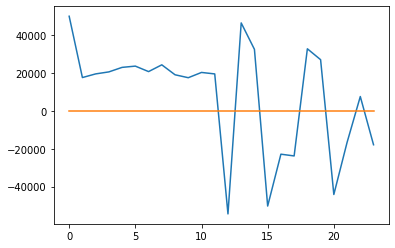

In [ ]:
import time
##################################  MAIN  #########################################
if __name__ == "__main__":
    global dias_pos
    global dias_neg
    sum_rewards_total = 0
    modelo.epsilon = 0.03
    sr=[]
    try:
        if carregar_pesos:
            modelo.carrega_pesos('./pesos.h5')
        epoca_parou = epoca_init
        for epoca in range(epoca_init, epocas): #rodar uma quantidade de epocas
            #s=time.time()
            sum_rewards = rodar_dias(inputs, custo) #adiciona o resultado da epoca na somatoria
            sum_rewards_total += sum_rewards
            sr.append(sum_rewards)
            print("resultado da epoca {0} = {1:0.2f}".format(epoca, sum_rewards))
            print(dias_pos)
            print(dias_neg)
            epoca_parou += 1
            if ((epoca % 200) == 0):
                modelo.salva_pesos('./pesos.h5')
            dias_pos = 0
            dias_neg = 0
            #e=time.time()
            #print(e-s)
            #modelo.epsilon -= epsilon_decay
    finally:
        print(dias_pos)
        print(dias_neg)
        modelo.salva_pesos('./pesos.h5')
        if carregar_epoca_epsilon:
            file = open("./epoca_epsilon.txt", "w")
            file.writelines("{0},{1}".format(epoca_parou, modelo.epsilon))
            file.close()
            print("parou na epoca {0} com epsilon {1}".format(epoca_parou, modelo.epsilon))
        print("Somatoria dos rewards: {0:0.2f}".format(sum_rewards_total))
        print("Melhor resultado diario: {0:0.2f}".format(melhor_reward))
        plt.plot(range(0, len(sr)), sr, range(0, len(sr)), np.zeros(len(sr))) #plota os valores de reward por epoca

[0, 106, 212, 318, 424, 530, 636, 742, 848, 954, 1060, 1166, 1272, 1378, 1484, 1590, 1696, 1802, 1908, 2014, 2120, 2226, 2332, 2438, 2544, 2650, 2756, 2862, 2968, 3074, 3180, 3286, 3392, 3498, 3604, 3710, 3816, 3922, 4028, 4134, 4240, 4346, 4452, 4558, 4664, 4770, 4876, 4982, 5088, 5194, 5300, 5406, 5512, 5618, 5724, 5830, 5936, 6042, 6148, 6254, 6360, 6466, 6572, 6678, 6784, 6890, 6996, 7102, 7208, 7314, 7420, 7526, 7632, 7738, 7844, 7950, 8056, 8162, 8268, 8374, 8480, 8586, 8692, 8798, 8904, 9010, 9116, 9222, 9328, 9434, 9540, 9646, 9752, 9858, 9964, 10070, 10176, 10282, 10388, 10494, 10600, 10706, 10812, 10918, 11024, 11130, 11236, 11342, 11448, 11554, 11660, 11766, 11872, 11978, 12084, 12190, 12296, 12402, 12508, 12614, 12720, 12826, 12932, 13038, 13144, 13250, 13356, 13462, 13568, 13674, 13780, 13886, 13992, 14098, 14204, 14310, 14416, 14522, 14628, 14734, 14840, 14946, 15052, 15158, 15264, 15370, 15476, 15582, 15688, 15794, 15900, 16006, 16112, 16218, 16324, 16430, 16536, 16642, 